# Randomizar datos

In [1]:
# IMPORTACIÓN DE LIBRERÍAS
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

In [2]:
# CARGA DE DATOS
url_cliente = "https://raw.githubusercontent.com/annaalfaro/EntregaTFM/main/Cliente.csv"
url_producto = "https://raw.githubusercontent.com/annaalfaro/EntregaTFM/main/Producto.csv"
url_ventas   = "https://raw.githubusercontent.com/annaalfaro/EntregaTFM/main/Ventas.csv"

#CARGA DE FICHEROS
Cliente = pd.read_csv(url_cliente)
Producto = pd.read_csv(url_producto)
Ventas = pd.read_csv(url_ventas)

In [3]:
# Preprocesamiento de datos
Producto["precio de venta (€)"] = Producto["precio de venta (€)"].str.replace(",", ".").astype(float)
Ventas["fecha"] = pd.to_datetime(Ventas["fecha"], dayfirst=True)

# Calcular patrones
productos_popularidad = Ventas["códigoproducto"].value_counts(normalize=True)
clientes_popularidad = Ventas["códigocliente"].value_counts(normalize=True)
Ventas['mes'] = Ventas['fecha'].dt.to_period('M')
ventas_mensuales = Ventas.groupby('mes')['unidades'].sum()
promedio_mensual_base = ventas_mensuales.groupby(ventas_mensuales.index.month).mean()

# Generar ventas nuevas
def generar_ventas_por_mes(anio):
    ventas = []
    for mes in range(1, 13):
        if mes in [11, 12]:
            total_unidades_mes = np.random.randint(6000, 8001)
        else:
            base = promedio_mensual_base.loc[mes]
            crecimiento = (anio - 2015) / (2024 - 2015)
            total_unidades_mes = int(base * (1 + crecimiento))

        unidades_generadas = 0
        fecha_inicio = datetime(anio, mes, 1)
        dias_en_mes = (datetime(anio if mes < 12 else anio+1, (mes % 12) + 1, 1) - fecha_inicio).days

        while unidades_generadas < total_unidades_mes:
            fecha = fecha_inicio + timedelta(days=np.random.randint(0, dias_en_mes))
            unidades = max(1, int(np.random.normal(loc=3, scale=2)))
            if unidades_generadas + unidades > total_unidades_mes:
                unidades = total_unidades_mes - unidades_generadas

            producto = np.random.choice(productos_popularidad.index, p=productos_popularidad.values)
            cliente = np.random.choice(clientes_popularidad.index, p=clientes_popularidad.values)
            precio_unitario = Producto.loc[Producto["códigoproducto"] == producto, "precio de venta (€)"].values[0]
            preciototal = round(precio_unitario * unidades, 2)
            ventas.append([fecha, cliente, producto, unidades, preciototal])
            unidades_generadas += unidades

    return ventas

In [4]:
# Ejecutar generación
ventas_nuevas = []
for anio in range(2016, 2025):
    ventas_nuevas.extend(generar_ventas_por_mes(anio))

# Crear DataFrame
Ventas_nuevas = pd.DataFrame(ventas_nuevas, columns=[
    'fecha', 'códigocliente', 'códigoproducto', 'unidades', 'preciototal'
])
Ventas_nuevas["fecha"] = pd.to_datetime(Ventas_nuevas["fecha"])

# Unificar, limpiar y ordenar
Ventas_total = pd.concat([Ventas.drop(columns=['mes'], errors='ignore'), Ventas_nuevas], ignore_index=True)
Ventas_total = Ventas_total.sort_values(by="fecha").reset_index(drop=True)
# Reasignar códigos de ventas ordenadamente
Ventas_total["códigoventas"] = ["V{:09d}".format(i) for i in range(len(Ventas_total))]

# Reorganizar columnas
Ventas_total = Ventas_total[["códigoventas", "fecha", "códigocliente", "códigoproducto", "unidades", "preciototal"]]


In [5]:
# Visualizar para ver que todo esta OK
print(Ventas_total)

      códigoventas      fecha códigocliente códigoproducto  unidades  \
0       V000000000 2014-01-02         C0008     B018IZ0SWI       2.0   
1       V000000001 2014-01-02         C0004     B01DZJFWNC       1.0   
2       V000000002 2014-01-02         C0000     B01DZJFWNC       2.0   
3       V000000003 2014-01-02         C0001     B016381QZA       4.0   
4       V000000004 2014-01-03         C0005     B00J0O5J4Y       2.0   
...            ...        ...           ...            ...       ...   
79692   V000079692 2024-12-31         C0050     B01KBH547A       1.0   
79693   V000079693 2024-12-31         C0000     B018IZ0SWI       2.0   
79694   V000079694 2024-12-31         C0010     B01DZJFWNC       2.0   
79695   V000079695 2024-12-31         C0053     B01EYT1URO       3.0   
79696   V000079696 2024-12-31         C0017     B01LQV1YHO       1.0   

       preciototal  
0           774.36  
1           238.62  
2           477.24  
3          1927.76  
4           804.48  
...      

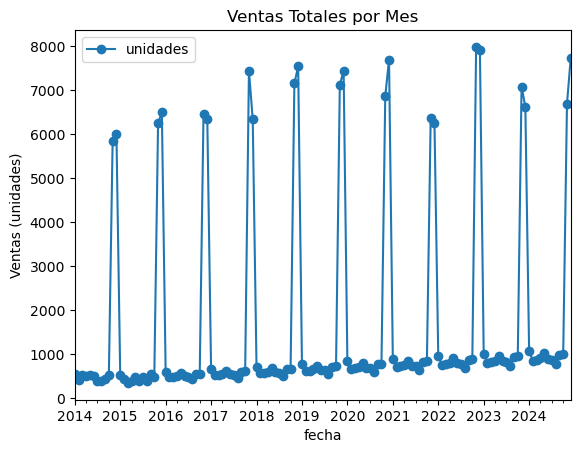

         mes  unidades      fecha
0    2014-01     545.0 2014-01-01
1    2014-02     422.0 2014-02-01
2    2014-03     523.0 2014-03-01
3    2014-04     505.0 2014-04-01
4    2014-05     535.0 2014-05-01
..       ...       ...        ...
127  2024-08     772.0 2024-08-01
128  2024-09     991.0 2024-09-01
129  2024-10    1009.0 2024-10-01
130  2024-11    6692.0 2024-11-01
131  2024-12    7739.0 2024-12-01

[132 rows x 3 columns]


In [12]:
#  Gráfica total mensual
ventas_mensuales = Ventas_total.copy()
ventas_mensuales["mes"] = ventas_mensuales["fecha"].dt.to_period("M")
ventas_mensuales = ventas_mensuales.groupby("mes")["unidades"].sum().reset_index()
ventas_mensuales["fecha"] = ventas_mensuales["mes"].dt.to_timestamp()

ventas_mensuales.plot(x='fecha', y='unidades', marker='o', title='Ventas Totales por Mes')
plt.ylabel("Ventas (unidades)")
plt.show()

print(ventas_mensuales)

In [13]:
# Gráfico por producto
ventas_producto = Ventas_total.copy()
ventas_producto["mes"] = ventas_producto["fecha"].dt.to_period("M")
ventas_producto = ventas_producto.groupby(["mes", "códigoproducto"])["unidades"].sum().reset_index()
ventas_producto["fecha"] = ventas_producto["mes"].dt.to_timestamp()
tabla_productos = ventas_producto.pivot(index="fecha", columns="códigoproducto", values="unidades").fillna(0)

fig = go.Figure()
for producto in tabla_productos.columns:
    fig.add_trace(go.Scatter(
        x=tabla_productos.index,
        y=tabla_productos[producto],
        mode='lines+markers',
        name=producto,
        hovertemplate='Mes: %{x}<br>Unidades: %{y}<extra>Producto: ' + producto + '</extra>'
    ))
fig.update_layout(
    title='Unidades Vendidas por Producto (Mensual)',
    xaxis_title='Mes',
    yaxis_title='Unidades',
    hovermode='x unified',
    height=600,
    template='plotly_white'
)
fig.show()

print(tabla_productos)

códigoproducto  B00F3J4B5S  B00J0O5J4Y  B00K15Q2B0  B00NQGP42Y  B015YCRYZM  \
fecha                                                                        
2014-01-01            61.0        14.0        44.0        68.0         4.0   
2014-02-01            59.0        26.0        49.0        26.0        18.0   
2014-03-01            46.0        16.0        51.0        51.0         7.0   
2014-04-01            62.0         9.0        53.0        63.0        28.0   
2014-05-01            73.0         9.0        60.0        52.0        22.0   
...                    ...         ...         ...         ...         ...   
2024-08-01            62.0        35.0        62.0       102.0        38.0   
2024-09-01           194.0        26.0       152.0        90.0        26.0   
2024-10-01           155.0        41.0       125.0       111.0        27.0   
2024-11-01           780.0       191.0       916.0       652.0       186.0   
2024-12-01           991.0       258.0      1012.0       691.0  

In [14]:
# Gráfico por cliente
ventas_cliente = Ventas_total.copy()
ventas_cliente["mes"] = ventas_cliente["fecha"].dt.to_period("M")
ventas_cliente = ventas_cliente.groupby(["mes", "códigocliente"])["unidades"].sum().reset_index()
ventas_cliente["fecha"] = ventas_cliente["mes"].dt.to_timestamp()
tabla_clientes = ventas_cliente.pivot(index="fecha", columns="códigocliente", values="unidades").fillna(0)

fig = go.Figure()
for cliente in tabla_clientes.columns:
    fig.add_trace(go.Scatter(
        x=tabla_clientes.index,
        y=tabla_clientes[cliente],
        mode='lines+markers',
        name=cliente,
        hovertemplate='Mes: %{x}<br>Unidades: %{y}<extra>Cliente: ' + str(cliente) + '</extra>'
    ))
fig.update_layout(
    title='Unidades Compradas por Cliente (Mensual)',
    xaxis_title='Mes',
    yaxis_title='Unidades',
    hovermode='x unified',
    height=600,
    template='plotly_white'
)
fig.show()

print(tabla_clientes)

códigocliente  C0000  C0001  C0002  C0003  C0004  C0005  C0006  C0007  C0008  \
fecha                                                                          
2014-01-01      33.0   18.0   12.0   14.0   13.0   14.0   44.0   33.0   33.0   
2014-02-01       0.0    6.0    6.0    5.0   20.0    6.0    3.0    4.0    3.0   
2014-03-01       0.0   18.0    6.0    4.0    3.0    4.0    5.0    3.0    5.0   
2014-04-01       0.0    5.0    5.0   18.0    5.0    3.0    6.0   16.0    4.0   
2014-05-01       2.0    6.0   17.0    8.0    8.0   21.0    6.0    8.0    6.0   
...              ...    ...    ...    ...    ...    ...    ...    ...    ...   
2024-08-01       3.0   11.0   17.0    4.0   10.0   10.0   11.0    3.0    2.0   
2024-09-01       0.0   14.0   11.0   22.0    5.0   22.0   15.0   10.0   10.0   
2024-10-01       3.0   19.0   21.0   29.0   19.0   22.0   15.0   22.0   24.0   
2024-11-01      18.0   74.0  146.0  132.0   91.0   79.0  103.0  125.0   79.0   
2024-12-01      39.0  130.0  100.0  134.

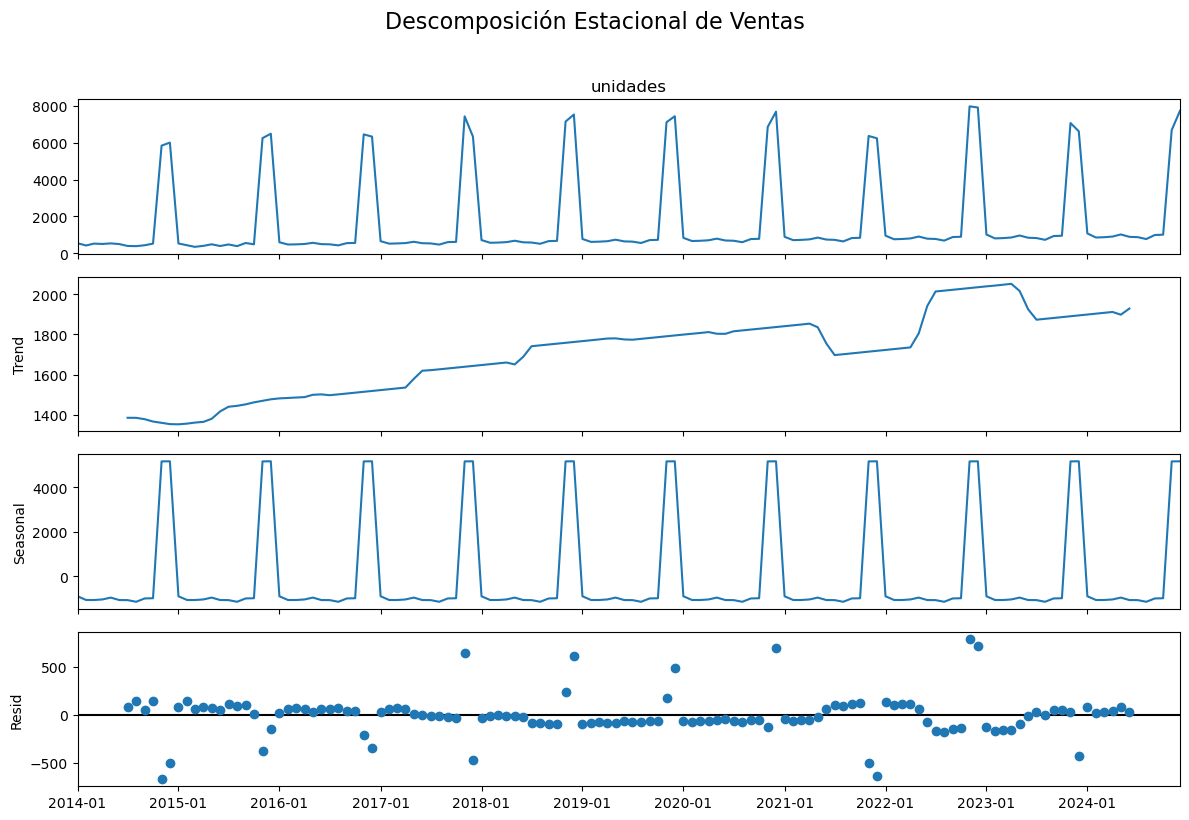

In [15]:
# Descomposición estacional mensual
ventas_mensuales_ts = Ventas_total.copy()
ventas_mensuales_ts["mes"] = ventas_mensuales_ts["fecha"].dt.to_period("M")
ventas_mensuales_ts = ventas_mensuales_ts.groupby("mes")["unidades"].sum().reset_index()
ventas_mensuales_ts["fecha"] = ventas_mensuales_ts["mes"].dt.to_timestamp()

# Crear serie temporal
serie = ventas_mensuales_ts.set_index("fecha")["unidades"]

# Descomposición estacional aditiva (12 meses)
resultado = seasonal_decompose(serie, model='additive', period=12)

fig = resultado.plot()
fig.set_size_inches(12, 8)
plt.suptitle("Descomposición Estacional de Ventas", fontsize=16, y=1.02)

# Formato fechas eje x
for ax in fig.axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.set_xlabel("")

plt.tight_layout()
plt.show()

Ventas por día de la semana:

día semana
Monday       32625.0
Tuesday      32341.0
Wednesday    32262.0
Thursday     32145.0
Friday       32752.0
Saturday     31936.0
Sunday       31647.0
Name: unidades, dtype: float64


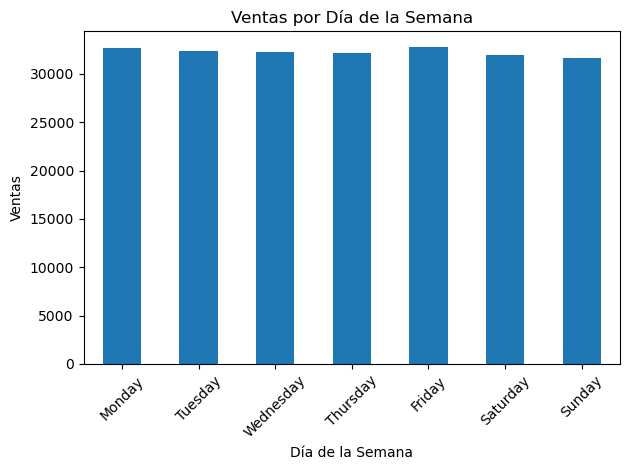

In [16]:
# Ventas por día de la semana
Ventas_total["día semana"] = Ventas_total["fecha"].dt.day_name()
ventas_semana = Ventas_total.groupby("día semana")["unidades"].sum().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

print("Ventas por día de la semana:\n")
print(ventas_semana)

ventas_semana.plot(kind='bar', title='Ventas por Día de la Semana')
plt.ylabel("Ventas")
plt.xlabel("Día de la Semana")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
# Guardar resultado
Ventas_total.to_csv("Ventas_2014-2024.csv", index=False)